# **1. 데이터 전처리**

## **구글 드라이브 연동**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/Shareddrives/KRX_공모전')

## **KRX에 상장된 종목 데이터 로드**

In [3]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import FinanceDataReader as fdr

# 회사명: Name / 종목코드: Symbol / 업종: Sector / 주요제품: Industry / 상장일: ListingDate / 결산월: SettleMonth / 대표자명: Representative / 홈페이지: HomePage / 지역: Region
df_krx = fdr.StockListing("KRX")
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


금융 데이터 수집 라이브러리인 FinanceDataReader를 사용하여 데이터를 수집하였다.  

## **필요 없는 변수 제거**

In [5]:
df_krx.drop(['Industry','Representative','HomePage','Region'], axis = 1, inplace = True)

먼저 KRX에 상장된 종목 데이터를 불러온 후, 주식 예측에 사용하지 않을 변수인 주요제품(Industry), 대표자명(Representative), 홈페이지(HomePage), 지역(Region) 을 제거하였다. 

## **2020년 이후 상장된 종목만 남기고 필터링**

In [6]:
from datetime import datetime, timedelta

end_date = datetime(2022,7,13) - timedelta(weeks = 7)
end_date = end_date.strftime("%Y-%m-%d")

In [7]:
df_krx_2020 = df_krx[(df_krx['ListingDate'] >= "2020-01-01") & (df_krx['ListingDate'] <= end_date)]
df_krx_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 85 to 7937
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Symbol       282 non-null    object        
 1   Market       282 non-null    object        
 2   Name         282 non-null    object        
 3   Sector       282 non-null    object        
 4   ListingDate  282 non-null    datetime64[ns]
 5   SettleMonth  282 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 15.4+ KB


KRX에 상장된 전체 종목에 대해 2020년 이후 상장된 종목이면서, 상장후 (주말, 공휴일 제외) 30일까지의 주식 데이터가 있는 종목을 추출하고자 한다.     
데이터 수집 시점을 기준으로 7주 전인 2022-05-25 를 end_date로 두고, 상장일이 2020-01-01 ~ 2022-05-25 인 종목만 남기고 필터링하였다.

## **Sector 변수 재범주화**

In [8]:
df_krx_2020.Sector.nunique()

66

업종(Sector) 변수의 범주 개수는 66개인데, 범주 개수가 많을 경우 인코딩을 했을 때 차원이 증가하며 sparse한 데이터로 바뀌어 예측에 좋지 않으므로 범주 개수를 줄이는 재범주화를 진행하고자 한다.  

In [9]:
# https://seibro.or.kr 에서 다운받은 csv 파일
kospi = pd.read_csv("data/kospi.csv")
kosdaq = pd.read_csv("data/kosdaq.csv")
konex = pd.read_csv("data/konex.csv")
sector_info = pd.concat([kospi, kosdaq, konex], axis = 0)
sector_info = sector_info[['종목코드','업종(대분류)']]
sector_info.columns = ['종목코드','업종명']
sector_info.head()

,종목코드,업종명
0,044380,IT
1,097520,IT
2,092220,IT
3,33626L,IT
4,33626K,IT


In [10]:
# 경기소비재: 경기관련소비재 / 의료: 건강관리 / 통신서비스: 커뮤니케이션서비스
sector_info.업종명.unique()

array(['IT', '경기소비재', '금융', '산업재', '소재', '에너지', '유틸리티', '의료', '통신서비스',
       '필수소비재', nan], dtype=object)

증권정보포털 (https://seibro.or.kr) 에서 다운받은 종목별 업종 분류 데이터를 이용하여 국내 주식시장에서 대표적으로 사용하는 WICS 대분류로 재범주화하고자 한다.  
* WICS 대분류: 에너지, 소재, 산업재, 경기관련소비재, 필수소비재, 건강관리, 금융, IT, 커뮤니케이션서비스, 유틸리티

In [11]:
df_krx_2020_new = pd.merge(df_krx_2020, sector_info, left_on = 'Symbol', right_on = '종목코드', how = 'left')
df_krx_2020_new.drop(['종목코드'], axis = 1, inplace = True)

기존 데이터 (df_krx_2020) 와 WICS 분류 데이터 (sector_info) 를 종목코드를 기준으로 결합하였다.  

In [12]:
df_krx_2020_new[df_krx_2020_new['업종명'].isna()].head()

,Symbol,Market,Name,Sector,ListingDate,SettleMonth,업종명
4,365550,KOSPI,ESR켄달스퀘어리츠,부동산 임대 및 공급업,2020-12-23,05월,NaN
8,343090,KONEX,HLB사이언스,의료용품 및 기타 의약 관련제품 제조업,2020-04-24,12월,NaN
15,400760,KOSPI,NH올원리츠,부동산 임대 및 공급업,2021-11-18,12월,NaN
18,395400,KOSPI,SK리츠,부동산 임대 및 공급업,2021-09-14,03월,NaN
31,257990,KONEX,나우코스,기타 화학제품 제조업,2020-12-30,12월,NaN


In [13]:
df_krx_2020_new.loc[df_krx_2020_new['업종명'].isna(),'업종명'] = ['금융','의료','금융','금융','소재','통신서비스','금융',
                                                         'IT','경기소비재','의료','금융','금융','의료','경기소비재',
                                                         '금융','소재','필수소비재','통신서비스','소재','산업재','금융',
                                                         '금융','금융','소재','산업재','의료','금융','금융',
                                                         '산업재','IT','IT']

결합되지 않고 NA로 남아있는 업종명은 WISC 표 (https://www.wiseindex.com/About/WICS) 를 참고하여 직접 채워주었다.

In [14]:
df_krx_2020_new.drop(['Sector'], axis = 1, inplace = True)
df_krx_2020_new.columns

Index(['Symbol', 'Market', 'Name', 'ListingDate', 'SettleMonth', '업종명'], dtype='object')

In [15]:
df_krx_2020_new.columns = ['Symbol', 'Market', 'Name', 'ListingDate', 'SettleMonth', 'Sector']

기존의 업종 변수는 제거하였고, 재범주화한 업종 변수는 Sector로 변수명을 바꿔주었다.

## **SettleMonth 변수 변환**

In [16]:
df_krx_2020_new['SettleMonth'] = df_krx_2020_new['SettleMonth'].str.replace('월','').astype(int)

결산월 (SettleMonth) 변수에 대해 '월'을 제거한 후 수치형 변수로 변환하였다.

## **추출된 상장 종목에 대해 주식 데이터 로드 및 추가 변수 생성**

In [17]:
import numpy as np
from itertools import combinations, chain

df = pd.DataFrame()

for idx in range(len(df_krx_2020_new)):
  
  stock = df_krx_2020_new.loc[idx,'Symbol']
  start_date = df_krx_2020_new.loc[idx,'ListingDate']

  # 각 종목에 대해 상장일부터의 주식 데이터 로드
  temp_df = fdr.DataReader(stock,start = start_date)
  # 행 번호 -> Date 변수
  temp_df.reset_index(inplace = True)
  # Date: 해당 개장일
  # Open / High / Low / Close: Date의 시가 / 고가 / 저가 / 종가
  # Volume: Date의 거래량
  # Change: Date의 전날 대비 종가 상승률

  # 상장후 7일부터 30일까지 투자할 수 있는 모든 경우의 데이터
  comb_df = pd.DataFrame()

  for i,comb in enumerate(combinations(range(7,31),2)):

    # 투자 시작일, 종료일 인덱스
    start = comb[0]
    end = comb[1]

    # 투자 시작 직전일 정보
    comb_df.loc[i,'invest_befor_Open'] = temp_df.loc[start-1,'Open']
    comb_df.loc[i,'invest_befor_High'] = temp_df.loc[start-1,'High']
    comb_df.loc[i,'invest_befor_Low'] = temp_df.loc[start-1,'Low']
    comb_df.loc[i,'invest_befor_Close'] = temp_df.loc[start-1,'Close']
    comb_df.loc[i,'invest_befor_Volume'] = temp_df.loc[start-1,'Volume']

    # 투자 기간
    comb_df.loc[i,'invest_DateDiff'] = start
    comb_df.loc[i,'invest_Duration'] = end - start

    # 투자 수익률 = (투자 종료일 종가 - 투자 시작일 종가) / (투자 시작일 종가)
    comb_df.loc[i,'value'] = temp_df.loc[end,'Close'] / temp_df.loc[start,'Close'] - 1
  
  # 종목 코드
  comb_df['Symbol'] = stock
  
  # 상장일 Day + n 정보 (n = 0, 1, ..., 6)
  for n in range(7):
    comb_df[str(n) + "day_Open"] = temp_df.loc[n,"Open"]
    comb_df[str(n) + "day_High"] = temp_df.loc[n,"High"]
    comb_df[str(n) + "day_Low"] = temp_df.loc[n,"Low"]
    comb_df[str(n) + "day_Close"] = temp_df.loc[n,"Close"]
    comb_df[str(n) + "day_Volume"] = temp_df.loc[n,"Volume"]

    if n != 0:
      comb_df[str(n)+"day_Date"] = temp_df.loc[n,"Date"]

  df = pd.concat([df,comb_df])

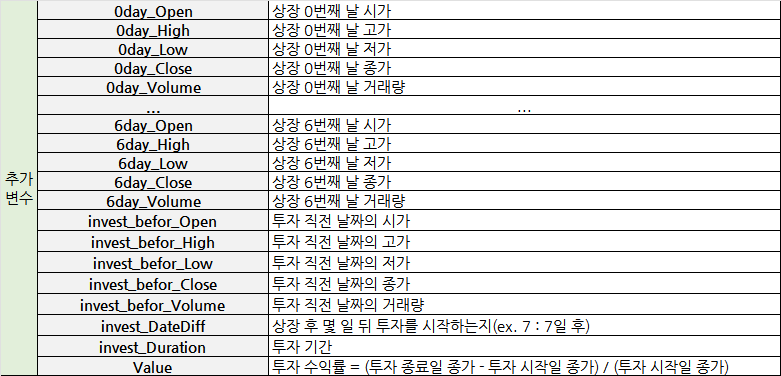

In [18]:
df_krx = df.merge(df_krx_2020_new, how = "left")

추가로 뉴스 기사 크롤링을 위하여 투자간 날짜 차이를 나타내는 변수를 생성한다.

In [20]:
df_krx['Datediff'] = df_krx['6day_Date'] - df_krx['ListingDate']
df_krx['Datediff'] = df_krx['Datediff'].dt.days

In [21]:
df_krx.head()

,invest_befor_Open,invest_befor_High,invest_befor_Low,invest_befor_Close,invest_befor_Volume,invest_DateDiff,invest_Duration,value,Symbol,0day_Open,...,6day_Low,6day_Close,6day_Volume,6day_Date,Market,Name,ListingDate,SettleMonth,Sector,Datediff
0,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,1.0,-0.007092,404950,2075,...,2095,2110,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8
1,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,2.0,-0.004728,404950,2075,...,2095,2110,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8
2,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,3.0,-0.002364,404950,2075,...,2095,2110,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8
3,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,4.0,-0.004728,404950,2075,...,2095,2110,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8
4,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,5.0,-0.004728,404950,2075,...,2095,2110,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8


---

# **2. 뉴스 크롤링 및 감성분석**

## **종가 변화**

In [22]:
df_close = df_krx[['Name','ListingDate','0day_Close','1day_Close','2day_Close','3day_Close','4day_Close','5day_Close','6day_Close']].drop_duplicates(ignore_index=True)

for i in range(0,6):
  df_close[str(i)+'to'+str(i+1)+'_Close'] = (df_close[str(i+1)+'day_Close'] - df_close[str(i)+'day_Close'])/df_close[str(i)+'day_Close']

df_close = df_close.drop(['0day_Close','1day_Close','2day_Close','3day_Close','4day_Close','5day_Close','6day_Close'], axis = 'columns')


df_close1 = df_close.iloc[0:200, :]
df_close2 = df_close.iloc[200:, :]
df_close

,Name,ListingDate,0to1_Close,1to2_Close,2to3_Close,3to4_Close,4to5_Close,5to6_Close
0,DB금융스팩10호,2022-01-20,0.078014,-0.067982,0.004706,-0.004684,-0.011765,0.004762
1,DB금융스팩8호,2020-12-09,0.000000,0.005038,-0.002506,0.000000,0.005025,0.000000
2,DB금융스팩9호,2021-03-16,0.000000,0.004950,0.000000,0.000000,0.000000,0.002463
3,DL이앤씨,2021-01-25,-0.007847,-0.071147,0.021278,-0.070840,0.058296,0.025435
4,ESR켄달스퀘어리츠,2020-12-23,0.003721,-0.017171,-0.007941,-0.001801,0.035485,-0.003872
...,...,...,...,...,...,...,...,...
277,한화플러스제2호스팩,2021-08-05,0.192308,-0.199194,-0.100705,0.000000,0.007839,-0.064444
278,해성티피씨,2021-04-21,0.102071,-0.092617,-0.105030,-0.018182,-0.045455,0.007055
279,현대중공업,2021-09-17,-0.111211,0.001009,-0.022177,0.030928,0.075000,0.074419
280,화승알앤에이,2021-03-15,-0.120513,-0.048105,0.062787,-0.028818,-0.014837,-0.028614


* 기존 df_krx 데이터에서 상장 당일부터 6일후까지 종가 변화를 가져온 뒤, 각 날짜별로 종가의 변화율을 나타내는 열을 추가하여 df_close 데이터프레임에 저장한다.  
"((n+1)_종가 - n_종가)/n_종가"

## **요일 변화**

In [23]:
import warnings
warnings.filterwarnings(action='ignore')

from datetime import datetime

temp = df_krx[['Name','ListingDate','1day_Date','2day_Date','3day_Date','4day_Date','5day_Date','6day_Date']].drop_duplicates(ignore_index=True)

for i in range(len(temp)):
    for j in range(1,8):
        temp.iloc[i,j] = datetime.strptime(str(temp.iloc[i,j]), '%Y-%m-%d 00:00:00').weekday()
        
temp.columns = ['Name',0, 1, 2, 3, 4, 5, 6]

for i in range(0,6):
    temp[str(i)+'to'+str(i+1)+'_daydiff'] = (temp[i+1] - temp[i] + 7)%7
    
    
    
for i in range(9,14):
    temp['0to'+str(i-7)+'_daydiff'] = temp['0to'+str(i-8)+'_daydiff'] + temp[str(i-8)+'to'+str(i-7)+'_daydiff']

temp['0to0_daydiff'] = 0

temp = temp[['0to0_daydiff','0to1_daydiff','0to2_daydiff','0to3_daydiff','0to4_daydiff','0to5_daydiff','0to6_daydiff']]

df_close = pd.concat([df_close, temp], axis = 1)

del temp

df_close

,Name,ListingDate,0to1_Close,1to2_Close,2to3_Close,3to4_Close,4to5_Close,5to6_Close,0to0_daydiff,0to1_daydiff,0to2_daydiff,0to3_daydiff,0to4_daydiff,0to5_daydiff,0to6_daydiff
0,DB금융스팩10호,2022-01-20,0.078014,-0.067982,0.004706,-0.004684,-0.011765,0.004762,0,1,4,5,6,7,8
1,DB금융스팩8호,2020-12-09,0.000000,0.005038,-0.002506,0.000000,0.005025,0.000000,0,1,2,5,6,7,8
2,DB금융스팩9호,2021-03-16,0.000000,0.004950,0.000000,0.000000,0.000000,0.002463,0,1,2,3,6,7,8
3,DL이앤씨,2021-01-25,-0.007847,-0.071147,0.021278,-0.070840,0.058296,0.025435,0,1,2,3,4,7,8
4,ESR켄달스퀘어리츠,2020-12-23,0.003721,-0.017171,-0.007941,-0.001801,0.035485,-0.003872,0,1,5,6,7,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,한화플러스제2호스팩,2021-08-05,0.192308,-0.199194,-0.100705,0.000000,0.007839,-0.064444,0,1,4,5,6,7,8
278,해성티피씨,2021-04-21,0.102071,-0.092617,-0.105030,-0.018182,-0.045455,0.007055,0,1,2,5,6,7,8
279,현대중공업,2021-09-17,-0.111211,0.001009,-0.022177,0.030928,0.075000,0.074419,0,6,7,10,11,12,13
280,화승알앤에이,2021-03-15,-0.120513,-0.048105,0.062787,-0.028818,-0.014837,-0.028614,0,1,2,3,4,7,8


* 주식 데이터는 공휴일과 주말을 제외한 평일의 데이터로만 구성되어있다.  
따라서 해당 날짜와 다음 날짜의 간격이 하루차이가 아닐 수도 있다.
* 위 요일 변화 데이터는 상장일로부터 다음 값이 적혀있는 날짜가 실제 며칠 차이가 나는지 확인해본 것이다. 예를 들어, "DB금융스팩10호"의 경우, 상장일 2022-01-20에 찍힌 값과 그로부터 2번 간격 뒤 찍힌 값의 날짜 간격은 '0to2_daydiff'값인 4일 간격이다.
* 최종적으로 요일 변화 데이터를 기존 종가 변화 데이터인 df_close 에 추가하였다.
* 이 중 주식 이름 기준 상위 200개 데이터는 후에 감성사전을 만들기 위한 train data로 사용할 예정이다.

In [24]:
df_name = df_close["Name"]

* 위 df_close 데이터에서 주식 이름만 따로 뽑아 df_name 에 저장했다.

## **각 주식별로 기사 제목, 날짜, 내용 크롤링**

In [25]:
df_unique = df_krx[["Name", "ListingDate", "Datediff"]].drop_duplicates(ignore_index=True)
df_unique1 = df_unique.iloc[0:200, :]
df_unique2 = df_unique.iloc[200:, :]

* df_krx 데이터에서 "Name", "ListingDate", "Datediff"만 따로 뽑아 df_unique 데이터를 만들었다.
* 주식 이름 기준 상위 200개 데이터만 df_unique1 데이터로 따로 뽑았고, 후에 감성사전을 만들기 위한 train data로 사용할 예정이다.

### **282개 주식 크롤링**

#### **train data 용 상위 200개 주식 (데이터 크기가 커서 10개씩 잘라서 저장)**
크롤링 시간이 너무 오래걸려 csv 파일로 저장 후 후에 다시 파일을 불러오는 방식으로 진행했다.

In [ ]:
import requests
from bs4 import BeautifulSoup
import datetime as dt
import pandas as pd
from tqdm import tqdm
import time
import random

df_unique = df_krx[["Name", "ListingDate", "Datediff"]].drop_duplicates(ignore_index=True)
df_unique1 = df_unique.iloc[0:200, :]
df_unique2 = df_unique.iloc[200:, :]

t = 0

for l in range(20):
    Name = []
    Title = []
    Date = []
    Contents = []
    
    for i in tqdm(range(10*l, 10*l + 10)) :
        n = 1

        # datetime.date(년도, 월, 일) 형식으로 변환
        temp_day = dt.datetime.strptime(df_unique1["ListingDate"][i], '%Y-%m-%d').date()
        temp_day_after5 = temp_day + dt.timedelta(days = + int(df_unique1["Datediff"][i]))

        while True:

            # 네이버 뉴스 400페이지까지만 제공 에러 방지
            if n == 4001:
                    break

            # 상장 당일부터 5일후까지 오래된 순으로 크롤링
            raw = requests.get('https://search.naver.com/search.naver?where=news&sort=2&query="'+df_unique1["Name"][i].replace('&', '%26')+
                               '"&start='+str(n)+
                               '&nso=so%3Add%2Cp%3Afrom'+temp_day.strftime("%Y%m%d")+'to'+temp_day_after5.strftime("%Y%m%d"),
                          headers={'User-Agent':'Mozilla/5.0'})

            time.sleep(3)

            html = BeautifulSoup(raw.text, "html.parser")

            articles = html.select("ul.list_news > li")

            if articles == []:
                break


            for ar in articles:
                news_title = ar.select_one("a.news_tit").text
                news_date = ar.select_one("span.info").text
                news_url = ar.select_one("a.news_tit").attrs['href']


                try : 
                    news_raw = requests.get(news_url, headers={'User-Agent':'Mozilla/5.0'})
                    news_html = BeautifulSoup(news_raw.text, "html.parser")
                    news_contents = news_html.get_text().replace('\n','')

                    Name.append(df_unique1["Name"][i])
                    Title.append(news_title)
                    Date.append(news_date)
                    Contents.append(news_contents)

                except : 
                    print([i, n, news_title, news_url])
                    t = t+1

                time.sleep(1.5)

            n += 10

    news_contents = pd.DataFrame(zip(Name, Date, Title, Contents), columns = ['Name', 'Date', 'Title', 'Contents'])
    news_contents['Date'] = news_contents['Date'].str.replace('.','-').str.rstrip('-')
    news_contents
    
    news_contents.to_csv("../data/news_temp_"+str(l)+".csv")

#### **test data 용 하위 82개 주식**
크롤링 시간이 너무 오래걸려 csv 파일로 저장 후 후에 다시 파일을 불러오는 방식으로 진행했다.

In [ ]:
df_unique = df_krx[["Name", "ListingDate"]].drop_duplicates(ignore_index=True)
df_unique1 = df_unique.iloc[0:200, :]
df_unique2 = df_unique.iloc[200:, :]

t = 0

Name = []
Title = []
Date = []
Contents = []

for i in tqdm(range(200, 297)) :
    n = 1

    # datetime.date(년도, 월, 일) 형식으로 변환
    temp_day = dt.datetime.strptime(df_unique2["ListingDate"][i], '%Y-%m-%d').date()
    temp_day_after5 = temp_day + dt.timedelta(days = + 5 )

    while True:

        # 네이버 뉴스 400페이지까지만 제공 에러 방지
        if n == 4001:
                break

        # 상장 당일부터 5일후까지 오래된 순으로 크롤링
        raw = requests.get('https://search.naver.com/search.naver?where=news&sort=2&query="'+df_unique2["Name"][i].replace('&', '%26')+
                           '"&start='+str(n)+
                           '&nso=so%3Add%2Cp%3Afrom'+temp_day.strftime("%Y%m%d")+'to'+temp_day_after5.strftime("%Y%m%d"),
                      headers={'User-Agent':'Mozilla/5.0'})

        time.sleep(3)

        html = BeautifulSoup(raw.text, "html.parser")

        articles = html.select("ul.list_news > li")

        if articles == []:
            break


        for ar in articles:
            news_title = ar.select_one("a.news_tit").text
            news_date = ar.select_one("span.info").text
            news_url = ar.select_one("a.news_tit").attrs['href']


            try : 
                news_raw = requests.get(news_url, headers={'User-Agent':'Mozilla/5.0'})
                news_html = BeautifulSoup(news_raw.text, "html.parser")
                news_contents = news_html.get_text().replace('\n','')

                Name.append(df_unique2["Name"][i])
                Title.append(news_title)
                Date.append(news_date)
                Contents.append(news_contents)

            except : 
                print([i, n, news_title, news_url])
                t = t+1

            time.sleep(1.5)

        n += 10

news_contents = pd.DataFrame(zip(Name, Date, Title, Contents), columns = ['Name', 'Date', 'Title', 'Contents'])
news_contents['Date'] = news_contents['Date'].str.replace('.','-').str.rstrip('-')
news_contents

news_contents.to_csv("../data/news_test.csv")

### **저장한 크롤링 데이터 다시 불러오기**


In [26]:
import pandas as pd

news_train = pd.read_csv("data/news_temp/news_temp_0.csv")
for i in range(1,20):
  temp = pd.read_csv("data/news_temp/news_temp_%d.csv" %i)
  news_train = pd.concat([news_train, temp], axis = 0, ignore_index = True)
  del temp

news_train = news_train.drop(news_train.columns[0], axis = 1)
news_test = pd.read_csv("data/news_temp/news_test.csv")
news_test = news_test.drop(news_test.columns[0], axis = 1)
news_contents = pd.concat([news_train, news_test], axis = 0, ignore_index = True)

In [27]:
news_train

,Name,Date,Title,Contents
0,DB금융스팩10호,2022-01-21,"[특징주] 성우테크론·손오공, 거래량 급증하며 주가 '강세'","[특징주] 성우테크론·손오공, 거래량 급증하며 주가 '강세'닫기Search#글로벌#..."
1,DB금융스팩8호,2020-12-09,[오늘의 증시] 포스코케미칼·인바이오젠·휴젤·에프앤가이드등,[오늘의 증시] 포스코케미칼·인바이오젠·휴젤·에프앤가이드등 - 이투데이 속보창구독신...
2,DB금융스팩8호,2020-12-11,[더벨]연말에도 싸늘한 스팩 투심…'안전 투자처' 매력 시들,NaN
3,DB금융스팩8호,2020-12-14,저금리+유동성 풍부…증시 '스팩'투자 관심,저금리+유동성 풍부…증시 '스팩'투자 관심로그인회원가입 AI앵커뉴스 메트로in ...
4,DB금융스팩9호,2021-03-16,[오늘의 증시] 네오이뮨텍ㆍ제이시스메디칼ㆍ크로바하이텍,[오늘의 증시] 네오이뮨텍ㆍ제이시스메디칼ㆍ크로바하이텍 - 이투데이 속보창구독신청RS...
...,...,...,...,...
27646,인카금융서비스,2022-02-23,[기관 매도 동향] 애드바이오텍 지분 7.5%p↓,[±â°ü ¸Åµµ µ¿Çâ] ¾Öµå¹ÙÀÌ¿ÀÅØ ÁöºÐ 7.5%p¡é - ¾...
27647,인카금융서비스,2022-02-24,"“불완전판매 1위 오명 씻겠다”… 피플라이프, 특단의 대책 내놔","“불완전판매 1위 오명 씻겠다”… 피플라이프, 특단의 대책 내놔 - 머니S본문영역 ..."
27648,인카금융서비스,4면 1단,"""살얼음판 증시·깐깐한 문턱"" IPO 가뭄 우려…상장 철회·연기 봇물","""살얼음판 증시·깐깐한 문턱"" IPO 가뭄 우려…상장 철회·연기 봇물 - 아시아경제..."
27649,인카금융서비스,2022-02-24,"인카금융서비스, 코스닥 입성 후 주가 내리막…7영업일 만에 30% 빠져","인카금융서비스, 코스닥 입성 후 주가 내리막…7영업일 만에 30% 빠져 TV LIV..."


* 상위 200개 종목 주식에 대한 주식 이름, 해당 뉴스 발행 날짜, 뉴스 제목, 뉴스 내용 크롤링한 결과를 news_train 데이터프레임으로 구현했다.

In [28]:
news_test

,Name,Date,Title,Contents
0,일진하이솔루스,A18면 TOP,일진하이솔루스 상장에 수소산업 부각…수소株 뜬다,일진하이솔루스 상장에 수소산업 부각…수소株 뜬다메인메뉴 바로가기컨텐츠 바로가기구독지...
1,일진하이솔루스,2021-09-01,[유가증권 메모] (1일) 신규상장=일진하이솔루스(271940) 등,유가증권 메모 1일 신규상장일진하이솔루스271940 등 | 한경닷컴본문 바로가기Fa...
2,일진하이솔루스,2021-09-01,"일진하이솔루스, 오늘 코스피 입성… 수소차 타고 '따상' 기대감↑","일진하이솔루스, 오늘 코스피 입성… 수소차 타고 '따상' 기대감↑ - 머니S본문영역..."
3,일진하이솔루스,2021-09-01,'공모 청약 흥행 성공' 수소株 일진하이솔루스 '따상' 가나,'ê³µëª¨ ì²­ì½ í¥í ì±ê³µ' ììæ ª ì¼ì§...
4,일진하이솔루스,2021-09-01,일진하이솔루스 오늘 상장…커지는 '따상' 기대,일진하이솔루스 오늘 상장…커지는 '따상' 기대메인메뉴 바로가기컨텐츠 바로가기구독지면...
...,...,...,...,...
12342,휴럼,2020-06-19,"YT1유산균, MBC 기분좋은날에서 소개","YT1유산균, MBC 기분좋은날에서 소개 2022년 07월 19일(화)구독신청기사제..."
12343,휴럼,2020-06-20,"특허청, 7월 3일까지 '혁신 아이디어 공모전' 참가작 접수","특허청, 7월 3일까지 '혁신 아이디어 공모전' 참가작 접수 < 로컬 IP < 특허..."
12344,휴럼,2020-06-20,"휴럼, ""YT1유산균, 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있...","휴럼, ""YT1유산균, 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있어"" ..."
12345,휴럼,2020-06-22,"곰보배추 섭취 방법...""위생적인 제조 방법이 중요""","곰보배추 섭취 방법...""위생적인 제조 방법이 중요"" - 한국면세뉴스 ×전체기사DF..."


* 하위 82개 종목 주식에 대한 주식 이름, 해당 뉴스 발행 날짜, 뉴스 제목, 뉴스 내용 크롤링한 결과를 news_train 데이터프레임으로 구현했다.

## **감성사전 만들기**

### **1. 저장한 csv 가져오기**

In [29]:
news_contents

,Name,Date,Title,Contents
0,DB금융스팩10호,2022-01-21,"[특징주] 성우테크론·손오공, 거래량 급증하며 주가 '강세'","[특징주] 성우테크론·손오공, 거래량 급증하며 주가 '강세'닫기Search#글로벌#..."
1,DB금융스팩8호,2020-12-09,[오늘의 증시] 포스코케미칼·인바이오젠·휴젤·에프앤가이드등,[오늘의 증시] 포스코케미칼·인바이오젠·휴젤·에프앤가이드등 - 이투데이 속보창구독신...
2,DB금융스팩8호,2020-12-11,[더벨]연말에도 싸늘한 스팩 투심…'안전 투자처' 매력 시들,NaN
3,DB금융스팩8호,2020-12-14,저금리+유동성 풍부…증시 '스팩'투자 관심,저금리+유동성 풍부…증시 '스팩'투자 관심로그인회원가입 AI앵커뉴스 메트로in ...
4,DB금융스팩9호,2021-03-16,[오늘의 증시] 네오이뮨텍ㆍ제이시스메디칼ㆍ크로바하이텍,[오늘의 증시] 네오이뮨텍ㆍ제이시스메디칼ㆍ크로바하이텍 - 이투데이 속보창구독신청RS...
...,...,...,...,...
39993,휴럼,2020-06-19,"YT1유산균, MBC 기분좋은날에서 소개","YT1유산균, MBC 기분좋은날에서 소개 2022년 07월 19일(화)구독신청기사제..."
39994,휴럼,2020-06-20,"특허청, 7월 3일까지 '혁신 아이디어 공모전' 참가작 접수","특허청, 7월 3일까지 '혁신 아이디어 공모전' 참가작 접수 < 로컬 IP < 특허..."
39995,휴럼,2020-06-20,"휴럼, ""YT1유산균, 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있...","휴럼, ""YT1유산균, 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있어"" ..."
39996,휴럼,2020-06-22,"곰보배추 섭취 방법...""위생적인 제조 방법이 중요""","곰보배추 섭취 방법...""위생적인 제조 방법이 중요"" - 한국면세뉴스 ×전체기사DF..."


### **2. 단어 전처리**

In [30]:
#1. 뉴스 제목과 기사에 숫자, 특수문자, 영어 없애기
news_contents['Title'] = news_contents['Title'].str.replace(pat=r'[^ 가-힣]',repl=r' ',regex=True)
news_contents['Contents'] = news_contents['Contents'].str.replace(pat=r'[^ 가-힣]',repl=r' ',regex=True)

# 2. 날짜 형식이 xxxx-xx-xx 아닌 행 삭제
news_contents = news_contents[news_contents['Date'].map(len) == 10]

# 3. NaN 처리
news_contents.Contents = news_contents.Contents.fillna('')

news_contents

,Name,Date,Title,Contents
0,DB금융스팩10호,2022-01-21,특징주 성우테크론 손오공 거래량 급증하며 주가 강세,특징주 성우테크론 손오공 거래량 급증하며 주가 강세 닫기 글로벌 ...
1,DB금융스팩8호,2020-12-09,오늘의 증시 포스코케미칼 인바이오젠 휴젤 에프앤가이드등,오늘의 증시 포스코케미칼 인바이오젠 휴젤 에프앤가이드등 이투데이 속보창구독신...
2,DB금융스팩8호,2020-12-11,더벨 연말에도 싸늘한 스팩 투심 안전 투자처 매력 시들,
3,DB금융스팩8호,2020-12-14,저금리 유동성 풍부 증시 스팩 투자 관심,저금리 유동성 풍부 증시 스팩 투자 관심로그인회원가입 앵커뉴스 메트로 ...
4,DB금융스팩9호,2021-03-16,오늘의 증시 네오이뮨텍 제이시스메디칼 크로바하이텍,오늘의 증시 네오이뮨텍 제이시스메디칼 크로바하이텍 이투데이 속보창구독신청 ...
...,...,...,...,...
39993,휴럼,2020-06-19,유산균 기분좋은날에서 소개,유산균 기분좋은날에서 소개 년 월 일 화 구독신청기사제...
39994,휴럼,2020-06-20,특허청 월 일까지 혁신 아이디어 공모전 참가작 접수,특허청 월 일까지 혁신 아이디어 공모전 참가작 접수 로컬 특허...
39995,휴럼,2020-06-20,휴럼 유산균 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있,휴럼 유산균 갱년기에 감소하는 에스트로겐과 장내유익균 잡아줄 수 있어 ...
39996,휴럼,2020-06-22,곰보배추 섭취 방법 위생적인 제조 방법이 중요,곰보배추 섭취 방법 위생적인 제조 방법이 중요 한국면세뉴스 전체기사 ...


* 기존 news_contents 데이터의 'Contents' 열에서 한글만 남기고 전처리를 시행했다.

### **3. 조사 제거 및 불용어처리**

In [31]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 63.2 MB/s 
     |████████████████████████████████| 453 kB 59.0 MB/s 


In [32]:
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from konlpy.tag import Okt

def NLP(word):
  okt = Okt()

  stop = "사람,아니,우리,때문,그것,그러나,그런,그리고,가지,지금,하나,자신,어떤,경우,생각,시간,그녀,다시,이런,다른,여자,사실,정도"

  stop_list = stop.split(',')
  word_tokens = okt.morphs(str(word)) #형태소 분석기로 토큰화

  tok = word_tokenize(word)

  def stopword(word_tokenize):
    result = []

    for w in word_tokenize:
      if w not in stop_list:
        result.append(w)
    
    return result
  
  return " ".join(stopword(word_tokens))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


* 특정 문장을 형태소 분석기로 토큰화하고 불용어는 삭제한 뒤, 다시 합치는 함수이다. 이 함수를 사용하면 한 글자의 조사 (은,는,이,가 등)의 경우 단어 사전에서 제외시킬 수 있다.

### **4. 사전 생성**

In [33]:
news_words = news_contents[["Name", "Date"]].drop_duplicates(ignore_index=True)
news_words

,Name,Date
0,DB금융스팩10호,2022-01-21
1,DB금융스팩8호,2020-12-09
2,DB금융스팩8호,2020-12-11
3,DB금융스팩8호,2020-12-14
4,DB금융스팩9호,2021-03-16
...,...,...
1778,휴럼,2020-06-17
1779,휴럼,2020-06-18
1780,휴럼,2020-06-19
1781,휴럼,2020-06-20


In [ ]:
from datetime import datetime
from tqdm import tqdm

vocab = {}

for i in tqdm(range(200)):
    Name = news_words['Name'][i]
    Date = news_words['Date'][i]
    Listdate = df_close[df_close['Name'] == Name].iloc[0,1]
    Daydiff = (datetime.strptime(Date, "%Y-%m-%d") - datetime.strptime(Listdate, "%Y-%m-%d")).days

    for i in range(8,14):
        if df_close[df_close['Name'] == Name].iloc[0,i] <= Daydiff < df_close[df_close['Name'] == Name].iloc[0,i+1]:
            weight = df_close[df_close['Name'] == Name].iloc[0,i-6]

    temp = news_contents[news_contents['Name'] == Name]
    temp = temp[temp['Date'] == Date].reset_index()


    for j in NLP(" ".join(temp['Contents'].values.tolist())).split(' '):
      if len(j) <= 1:
        pass
      elif j not in vocab:
        vocab[j] = weight
      else:
        vocab[j] += weight

news_dictionary = pd.DataFrame(vocab.items(), columns=['Word', 'Wordvalue'])

okt = Okt()

news_dictionary = news_dictionary[news_dictionary['Word'].str.contains("|".join(okt.nouns(" ".join(vocab.keys()))))]
news_dictionary.to_csv("data/news_dictionary.csv", index=False)

100%|██████████| 200/200 [44:09<00:00, 13.25s/it]


* train data인 상위 200개 종목에 대한 크롤링 자료로 감성분석을 진행하여 감성사전을 만든 결과이다.
* 해당 날짜에 해당하는 뉴스의 단어들을 뽑고, 해당 날짜와 다음 날짜간의 종가변화를 weight로 사용하여 '단어개수 * 종가 변화율'을 사전에 더하는 방식으로 사전 업데이트를 진행했다.
* 감성사전을 만드는 과정 역시 컴퓨팅 시간이 길어 감성 사전을 따로 csv 파일로 저장한 후, 후에 다시 해당 파일을 불러오는 방식으로 진행했다.

In [34]:
news_dictionary = pd.read_csv("data/news_dictionary.csv")
news_vocab = news_dictionary.set_index('Word').to_dict()['Wordvalue']

## **각 종목당 Score 추가**

In [35]:
from tqdm import tqdm

df_unique['Contents'] = 0
for i in tqdm(range(len(df_close))):
  Name = df_close['Name'][i]
  
  temp = news_contents[news_contents['Name'] == Name]
  df_unique['Contents'][i] = " ".join(temp['Contents'].values.tolist())

100%|██████████| 282/282 [00:01<00:00, 243.71it/s]


* 기존 news_contents에서 주식 종목의 이름이 같은 뉴스끼리 전부 모아 'Contents'열에 있는 뉴스 기사 내용들을 전부 하나의 문장으로 합쳐 df_unique 데이터프레임에 'Contents'열로 새로 추가했다.

In [36]:
total = []
for i,w  in tqdm(enumerate(df_unique['Contents'])):
    score = 0
    w= w.split(' ')
    for j in w:
        if(len(j)<=1):
          continue
        elif(j not in news_vocab):
          continue
        else:
          score = score + news_vocab[j]
    total.append(score/len(w))
df_unique['Score'] = total

282it [00:45,  6.26it/s]


* 282개 주식 종목 전부에 대하여, 상장 후 6일동안 크롤링한 기사 내용과 위에서 만든 감성사전으로 해당 주식의 점수 (Score)를 부여했다.

## **각 종목당 기사 개수 추가**

In [37]:
counts = []
for i in tqdm(range(len(df_close))):
  counts.append(np.sum(news_contents["Name"] == df_name[i]))

df_unique['Count'] = counts

100%|██████████| 282/282 [00:00<00:00, 363.54it/s]


* 282개 주식 종목 각각에 대해 상장 후 5일동안 나온 기사 전체 개수를 df_unique에 추가했다.

In [38]:
df_krx = pd.merge(df_krx, df_unique[['Name','Score', 'Count']], left_on = 'Name', right_on = 'Name', how = 'left')
df_krx

,invest_befor_Open,invest_befor_High,invest_befor_Low,invest_befor_Close,invest_befor_Volume,invest_DateDiff,invest_Duration,value,Symbol,0day_Open,...,6day_Volume,6day_Date,Market,Name,ListingDate,SettleMonth,Sector,Datediff,Score,Count
0,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,1.0,-0.007092,404950,2075,...,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8,46.977792,1
1,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,2.0,-0.004728,404950,2075,...,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8,46.977792,1
2,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,3.0,-0.002364,404950,2075,...,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8,46.977792,1
3,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,4.0,-0.004728,404950,2075,...,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8,46.977792,1
4,2110.0,2115.0,2095.0,2110.0,140411.0,7.0,5.0,-0.004728,404950,2075,...,140411,2022-01-28,KOSDAQ,DB금융스팩10호,2022-01-20,12,금융,8,46.977792,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77827,2860.0,2881.0,2853.0,2860.0,88253.0,27.0,2.0,0.000000,353190,2860,...,19104,2020-06-25,KOSDAQ,휴럼,2020-06-17,12,필수소비재,8,28.794611,9
77828,2860.0,2881.0,2853.0,2860.0,88253.0,27.0,3.0,-0.002442,353190,2860,...,19104,2020-06-25,KOSDAQ,휴럼,2020-06-17,12,필수소비재,8,28.794611,9
77829,2853.0,2867.0,2853.0,2867.0,1202.0,28.0,1.0,0.000000,353190,2860,...,19104,2020-06-25,KOSDAQ,휴럼,2020-06-17,12,필수소비재,8,28.794611,9
77830,2853.0,2867.0,2853.0,2867.0,1202.0,28.0,2.0,-0.002442,353190,2860,...,19104,2020-06-25,KOSDAQ,휴럼,2020-06-17,12,필수소비재,8,28.794611,9


* 최종적으로 282개 종목에 대하여 Score값과 기사 개수인 Count값을 처음 df_krx 데이터에 추가해 저장했다.

---

# **3. 기계학습 및 예측**  
회사가 상장을 한 후 7일차부터 투자를 할 경우 어떻게 투자를 하면 좋을지 추천해주는 알고리즘을 짜기 위하여 각 경우의 수익률 예측 모델을 학습하기로 한다. 여러 앙상블 기법 중 스태킹 앙상블(Stacking Ensemble)을 이용하기로 한다.

## **필요 패키지 장착**

In [66]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor 
import xgboost
from lightgbm import LGBMRegressor as lgb
!pip install vecstack
from vecstack import stacking
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **데이터 나누기**

In [41]:
remove_list = ['value','Symbol','Name','ListingDate','Datediff',
               '0day_Date', '1day_Date', '2day_Date', '3day_Date', '4day_Date', '5day_Date', '6day_Date']
variable = [i for i in list(df_krx.columns) if i not in remove_list]

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(df_krx[variable]), df_krx['value'], test_size = 82/282, shuffle = False)

# 확인
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (55200, 57)
X_test shape: (22632, 57)
y_train shape: (55200,)
y_test shape: (22632,)


## **예측값 변환**  
기존 값보다 높은 값으로 예측하는 경우 즉 Overestimating일 때 투자자의 입장에서 손실이 발생할 수 있으므로 더 큰 패널티를 주기로 한다. 이를 위해 metric으로 MSLE를 사용하기로 하고, Y의 부호를 바꾸어주었다. MSLE(mean squared log error)는 안에 양수만 있어야하므로 양수로 만들 수 있는 최소 정수를 더해준다. 또한 패널티의 정도를 더욱 주기 위하여 제곱 후 분석을 진행한다.

In [42]:
upper = round(df_krx["value"].max())
sqrt = 1/2
y_train = ((y_train * -1) + upper) ** (1/sqrt)
y_test = ((y_test * -1) + upper) ** (1/sqrt)

## **모델 생성**

In [43]:
# 1st level models
models = [RandomForestRegressor(n_estimators = 100, max_depth = 9, max_features = 'log2', criterion = 'mse', random_state = 0), 
          xgboost.XGBRegressor(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                        colsample_bynode = 1, colsample_bytree = 1, gamma = 1, importance_type = 'gain', 
                        max_delta_step = 0, max_depth = 4, learning_rate = 0.1, min_child_weight = 1, 
                        num_parallel_tree = 1, random_state = 0, n_jobs = 0, n_estimators = 100, reg_alpha = 0, reg_lambda = 20,
                        scale_pos_weight = 1, subsample = 1, tree_method = 'exact', validate_parameters = 1, verbosity = 0),
          lgb(boosting_type = 'dart', learning_rate = 0.01, n_jobs = 5, n_estimators = 100,
              num_leaves = 700, silent = True, max_depth = -1, max_bin = 255, colsample_bytree = 0.64, reg_alpha = 1.4,
              reg_lambda = 1, subsample = 0.7, min_split_gain = 0.5, min_child_weight = 23, min_child_samples = 5, random_state = 0)]

## **학습(스태킹 앙상블)**

In [44]:
# Stacking 1st level models
S_train, S_test = stacking(models, X_train, y_train, X_test, 
                           regression = True, metric = mean_squared_log_error, n_folds = 4, 
                           shuffle = True, random_state = 0) 

In [45]:
# 2nd level model 
model = xgboost.XGBRegressor(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                        colsample_bynode = 1, colsample_bytree = 1, gamma = 1, importance_type = 'gain',
                        max_delta_step = 0, max_depth = 4, learning_rate = 0.1, min_child_weight = 1, 
                        num_parallel_tree = 1, random_state = 0, n_jobs = 0, n_estimators = 100, reg_alpha = 0, reg_lambda = 20,
                        scale_pos_weight = 1, subsample = 1, tree_method = 'exact', validate_parameters = 1, verbosity = 0)

In [46]:
# Fit 2nd level model 
model = model.fit(S_train, y_train)

In [47]:
# Predict 
y_pred = model.predict(S_test) 

In [48]:
# Final prediction score 
print('Final prediction score(msle): [%.8f]' % mean_squared_log_error(y_test, y_pred))

Final prediction score(msle): [0.01263338]


## **Test 데이터를 이용한 종목 추천 및 수익률 확인**

패널티를 위해 바꾼 Y를 다시 원래의 값으로 복구

In [49]:
y_test = (y_test ** sqrt - upper) * -1
y_pred = (y_pred ** sqrt - upper) * -1

test data로 사용할 데이터 목록 추출

In [50]:
test_list = df_krx["Name"].drop_duplicates().iloc[200:282].reset_index(drop=True)

### **종목 추천 및 수익률 확인**  
각 일차별 투자할 수 있는 경우의 수 마다 수익률을 계산, 그 중 최댓값이 0보다 크다면 최댓값을 가지는 경우를 추천

In [51]:
from itertools import combinations, chain
pred_class = list(combinations(range(7,31),2))

variable = []
for i in range(7, 30):
  variable.append(str(i) + "일차 투자")

pred_invest = pd.DataFrame(index = test_list, columns = variable)
pred_result = pd.DataFrame(index = test_list, columns = variable)
for i in range(0, len(test_list)):
  k = 0

  for j in range(7, 30):
    temp = y_pred[(276*i+k):(276*i+k+30-j)]
    if temp.max() < 0:
      pred_invest.loc[test_list[i], variable[j-7]] = "No invest"
      pred_result.loc[test_list[i], variable[j-7]] = 0
    else:
      pred_invest.loc[test_list[i], variable[j-7]] = pred_class[np.where(temp == temp.max())[0][0]+k]
      pred_result.loc[test_list[i], variable[j-7]] =  y_test.iloc[276*i + np.where(temp == temp.max())[0][0]+k]
    k = k+30-j

In [52]:
pred_invest

,7일차 투자,8일차 투자,9일차 투자,10일차 투자,11일차 투자,12일차 투자,13일차 투자,14일차 투자,15일차 투자,16일차 투자,...,20일차 투자,21일차 투자,22일차 투자,23일차 투자,24일차 투자,25일차 투자,26일차 투자,27일차 투자,28일차 투자,29일차 투자
Name,,,,,,,,,,,,,,,,,,,,,
일진하이솔루스,"(7, 14)","(8, 9)","(9, 15)","(10, 11)","(11, 22)","(12, 13)","(13, 24)","(14, 25)","(15, 26)","(16, 21)",...,"(20, 27)","(21, 26)","(22, 27)","(23, 28)","(24, 29)","(25, 28)","(26, 27)","(27, 28)","(28, 29)","(29, 30)"
자이언트스텝,"(7, 26)","(8, 26)","(9, 27)","(10, 28)","(11, 29)","(12, 29)","(13, 21)","(14, 30)","(15, 29)","(16, 30)",...,"(20, 30)","(21, 27)","(22, 26)","(23, 29)","(24, 29)","(25, 28)","(26, 29)","(27, 29)","(28, 30)","(29, 30)"
제노코,"(7, 8)","(8, 17)",No invest,No invest,"(11, 22)","(12, 21)","(13, 14)",No invest,"(15, 26)","(16, 27)",...,"(20, 29)","(21, 27)","(22, 23)","(23, 29)","(24, 28)","(25, 26)","(26, 27)","(27, 28)","(28, 29)","(29, 30)"
제놀루션,"(7, 27)","(8, 27)","(9, 27)","(10, 28)","(11, 27)","(12, 28)","(13, 28)","(14, 30)","(15, 22)","(16, 17)",...,"(20, 29)","(21, 29)","(22, 26)","(23, 25)","(24, 30)","(25, 26)","(26, 28)","(27, 29)","(28, 29)","(29, 30)"
제이알글로벌리츠,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
한화플러스제2호스팩,"(7, 20)","(8, 20)","(9, 27)","(10, 24)","(11, 24)","(12, 25)","(13, 25)","(14, 27)","(15, 28)","(16, 28)",...,"(20, 30)","(21, 30)","(22, 30)",No invest,No invest,No invest,No invest,No invest,No invest,No invest
해성티피씨,"(7, 23)","(8, 17)","(9, 10)","(10, 23)","(11, 22)","(12, 23)","(13, 22)","(14, 26)","(15, 27)","(16, 23)",...,"(20, 27)","(21, 28)","(22, 29)","(23, 30)","(24, 28)","(25, 29)","(26, 30)","(27, 30)","(28, 29)","(29, 30)"
현대중공업,"(7, 17)","(8, 22)","(9, 21)","(10, 23)","(11, 21)","(12, 22)","(13, 27)","(14, 27)","(15, 28)","(16, 26)",...,"(20, 30)","(21, 30)","(22, 26)","(23, 24)","(24, 25)","(25, 26)","(26, 27)","(27, 28)","(28, 29)","(29, 30)"


**pred_invest 해석**
- 각 변수명은 투자를 하는 시점을 나타내고 원소값은 종목에 들어가는 날짜와 나오는 날짜이다.  
이때, 날짜는 단순 일수가 아닌 상장일 이후 주식 장이 열리는 n일 후 이다.
- No invest는 어떠한 경우에도 수익률이 음수로 예측이 되는 경우이다.

In [53]:
pred_result

,7일차 투자,8일차 투자,9일차 투자,10일차 투자,11일차 투자,12일차 투자,13일차 투자,14일차 투자,15일차 투자,16일차 투자,...,20일차 투자,21일차 투자,22일차 투자,23일차 투자,24일차 투자,25일차 투자,26일차 투자,27일차 투자,28일차 투자,29일차 투자
Name,,,,,,,,,,,,,,,,,,,,,
일진하이솔루스,-0.053232,-0.009412,-0.138955,-0.041667,-0.21867,0.005319,-0.05291,-0.026774,-0.004138,-0.197847,...,0.131746,0.211409,0.166939,-0.004255,0.043296,-0.034388,-0.012465,-0.015428,0.064103,0.024096
자이언트스텝,0.098537,-0.097218,-0.222558,-0.208425,-0.198378,-0.298947,-0.144445,-0.23734,-0.242306,-0.226833,...,-0.197536,-0.152766,-0.114429,-0.158121,-0.136904,-0.058656,-0.057407,-0.006321,-0.002561,-0.005058
제노코,0.086603,-0.06931,0,0,0.076465,0.016411,0.010425,0,-0.11153,-0.095558,...,-0.104977,-0.116685,-0.044409,-0.065028,-0.074076,-0.034648,-0.019887,0.003047,0.019256,-0.014959
제놀루션,-0.29109,-0.235927,-0.190351,-0.108415,-0.172485,-0.12954,-0.21875,-0.093368,0.042544,-0.030095,...,0.052759,0.029702,-0.061241,-0.078448,-0.013431,-0.003091,-0.029518,0.032924,0.054441,0.001515
제이알글로벌리츠,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
한화플러스제2호스팩,0.109459,-0.026097,-0.366702,-0.270358,-0.27115,-0.223256,-0.279396,-0.314709,-0.30591,-0.292798,...,-0.291108,-0.228117,-0.197241,0,0,0,0,0,0,0
해성티피씨,-0.30394,-0.148594,0.006466,-0.205567,-0.184382,-0.200431,-0.160714,-0.125581,-0.095923,-0.103865,...,-0.040712,-0.005333,-0.005319,0.002695,0.008108,-0.013193,-0.010638,-0.013263,0.002681,-0.005348
현대중공업,-0.105727,0.038278,-0.009346,0.03653,0.014354,0.074257,0.137255,0.137255,0.109524,0.167488,...,0.123762,0.070755,0.092166,-0.013216,0.044643,0.012821,-0.021097,0.00431,-0.034335,0.008889


**pred_result 해석**  
- 각 원소값은 pred_invest에 대응되는 원소에서 제시한 투자를 하였을 때, 수익률을 나타낸다.
- 투자를 안하는 경우를 제외하고 수익률 평균을 구하여 이 추천 알고리즘이 괜찮은 알고리즘인지 판단하기로 한다.

In [54]:
print('투자를 안하는 항목을 제외한 평균 수익률 :', sum(np.sum(pred_result)) / sum(np.sum(pred_invest != "No invest")))

투자를 안하는 항목을 제외한 평균 수익률 : 0.008943903184268827


- 양의 수익률이 나오긴 하였지만 투자의 안전성을 위하여 No invest를 하는 조건을 조금씩 올리면서 결과를 확인해볼 필요가 있어보인다.

## **투자 조건("No invest" 조건) 수정**

In [55]:
from tqdm import tqdm
results = []
counts = []
for l in tqdm(range(0, 100)):
  pred_invest = pd.DataFrame(index = test_list, columns = variable)
  pred_result = pd.DataFrame(index = test_list, columns = variable)
  for i in range(0, len(test_list)):
    k = 0

    for j in range(7, 30):
      temp = y_pred[(276*i+k):(276*i+k+30-j)]
      if temp.max() < l/100:
        pred_invest.loc[test_list[i], variable[j-7]] = "No invest"
        pred_result.loc[test_list[i], variable[j-7]] = 0
      else:
        pred_invest.loc[test_list[i], variable[j-7]] = pred_class[np.where(temp == temp.max())[0][0]+k]
        pred_result.loc[test_list[i], variable[j-7]] =  y_test.iloc[276*i + np.where(temp == temp.max())[0][0]+k]
      k = k+30-j

  counts.append(len(list(test_list[list(np.sum(pred_invest != "No invest", axis = 1)>0)])))
  if sum(np.sum(pred_invest != "No invest")) != 0:
    results.append(sum(np.sum(pred_result)) / sum(np.sum(pred_invest != "No invest")))
  else:
    results.append(0)

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


In [56]:
print("수익률 평균을 최대로 만드는 조건 :", np.argmax(results)/100, 
      "\n", "최대 수익률 평균 :", np.max(results),
      "\n", "최대 수익률 종목 추천 수 :", counts[np.argmax(results)])

수익률 평균을 최대로 만드는 조건 : 0.38 
 최대 수익률 평균 : 0.8772469927746155 
 최대 수익률 종목 추천 수 : 1


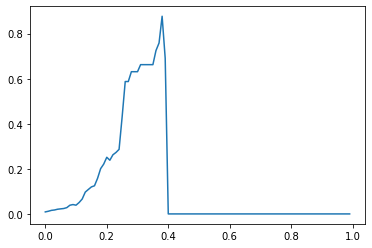

In [68]:
plt.plot(list(np.arange(0, 1, 0.01)), results)

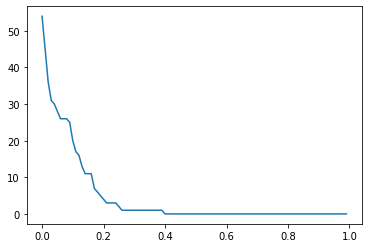

In [69]:
plt.plot(list(np.arange(0, 1, 0.01)), counts)

**투자 조건별 결과 해석**  
- 투자 조건이 어느정도 올라갈수록 수익률은 증가한다.
- 투자 조건이 올라갈수록 투자하는 회사 수는 감소한다.
- 수익률이 높지만 추천 회사 수가 적으면 위험성이 크므로 적당히 절충을 할 필요가 있어보인다.

## **최종 예측 모형 생성**  
82개 회사 중 10개 이상 회사를 추천하기 위하여 투자 조건을 0.16으로 설정하기로한다.

In [59]:
pred_invest = pd.DataFrame(index = test_list, columns = variable)
pred_result = pd.DataFrame(index = test_list, columns = variable)
for i in range(0, len(test_list)):
  k = 0

  for j in range(7, 30):
    temp = y_pred[(276*i+k):(276*i+k+30-j)]
    if temp.max() < 0.16:
      pred_invest.loc[test_list[i], variable[j-7]] = "No invest"
      pred_result.loc[test_list[i], variable[j-7]] = 0
    else:
      pred_invest.loc[test_list[i], variable[j-7]] = pred_class[np.where(temp == temp.max())[0][0]+k]
      pred_result.loc[test_list[i], variable[j-7]] =  y_test.iloc[276*i + np.where(temp == temp.max())[0][0]+k]
    k = k+30-j

**투자 회사 목록**

In [60]:
test_list[list(np.sum(pred_invest != "No invest", axis = 1)>0)]

1         자이언트스텝
5          제이앤티씨
9           젠큐릭스
14    지앤비에스엔지니어링
17          진시스템
26    켄코아에어로스페이스
27            켈스
56       피엔에이치테크
58          피코그램
59         피플바이오
60            핌스
Name: Name, dtype: object

In [61]:
pred_invest.loc[list(test_list[list(np.sum(pred_invest != "No invest", axis = 1)>0)]),]

,7일차 투자,8일차 투자,9일차 투자,10일차 투자,11일차 투자,12일차 투자,13일차 투자,14일차 투자,15일차 투자,16일차 투자,...,20일차 투자,21일차 투자,22일차 투자,23일차 투자,24일차 투자,25일차 투자,26일차 투자,27일차 투자,28일차 투자,29일차 투자
Name,,,,,,,,,,,,,,,,,,,,,
자이언트스텝,"(7, 26)","(8, 26)",No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
제이앤티씨,"(7, 22)","(8, 24)","(9, 24)","(10, 25)","(11, 26)","(12, 27)","(13, 28)","(14, 29)","(15, 28)","(16, 30)",...,"(20, 30)","(21, 30)","(22, 30)","(23, 30)",No invest,No invest,No invest,No invest,No invest,No invest
젠큐릭스,No invest,No invest,No invest,"(10, 23)","(11, 23)",No invest,No invest,No invest,No invest,No invest,...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
지앤비에스엔지니어링,"(7, 18)","(8, 20)","(9, 20)","(10, 27)","(11, 22)","(12, 23)","(13, 30)","(14, 25)","(15, 24)","(16, 27)",...,"(20, 30)","(21, 30)","(22, 30)","(23, 29)",No invest,No invest,No invest,No invest,No invest,No invest
진시스템,No invest,No invest,No invest,No invest,No invest,No invest,No invest,"(14, 27)","(15, 28)","(16, 27)",...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
켄코아에어로스페이스,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,"(15, 26)",No invest,...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
켈스,No invest,No invest,No invest,"(10, 27)","(11, 28)","(12, 29)",No invest,No invest,No invest,No invest,...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
피엔에이치테크,No invest,No invest,"(9, 22)","(10, 23)",No invest,No invest,"(13, 26)","(14, 27)","(15, 28)","(16, 27)",...,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest,No invest
피코그램,"(7, 21)","(8, 24)","(9, 25)","(10, 27)","(11, 29)","(12, 30)","(13, 28)","(14, 29)","(15, 26)","(16, 27)",...,"(20, 28)","(21, 29)","(22, 30)","(23, 24)","(24, 30)","(25, 30)","(26, 27)","(27, 28)","(28, 29)","(29, 30)"


In [63]:
print('투자를 안하는 항목을 제외한 평균 수익률 :', sum(np.sum(pred_result)) / sum(np.sum(pred_invest != "No invest")))

투자를 안하는 항목을 제외한 평균 수익률 : 0.124906404269492


---

# **4. 결과 해석**

처음 신규 상장 회사의 7일간 데이터를 이용하여 예측하였을 때는 예상 수익률 평균이 3%정도였는데, 뉴스 데이터를 추가하니 12% 정도로 크게 상승하였다. 신규 상장 회사이므로 재무제표에 대한 정보가 없는 회사들이 있어 이번 분석에는 활용하지 못했지만 향후 회사에 대한 정보를 추가하여 모델을 더욱 강화시킬 수 있을 것으로 보인다.